## Introduction
Microplastic pollution is a significant environmental challenge affecting marine ecosystems, wildlife, and human health. Detecting microplastic particles in underwater images is a complex task due to varying lighting conditions, water turbidity, and the small size of plastic particles. This project aims to address this challenge using a deep learning approach to accurately classify images as either "plastic" or "no plastic."

Problem: <br>
Marine environments are increasingly contaminated with microplastic particles, which are difficult to detect manually in underwater images. Traditional methods of monitoring these pollutants are time-consuming and labor-intensive.

Goal: <br>
Develop a machine learning model that can automatically detect and classify microplastic particles in underwater images. This tool will aid environmental scientists and policymakers in monitoring plastic pollution and making informed decisions about marine conservation efforts.

## Goal of this project
The primary objective of this project is to develop a robust classifier that can effectively distinguish between images containing plastic and those without plastic using deep learning techniques. To improve detection accuracy, the model leverages transfer learning with MobileNetV2, utilizing pre-trained features to enhance performance compared to training a network from scratch. Additionally, to efficiently process multiple images, a batch prediction pipeline is implemented, enabling rapid classification of large datasets.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [3]:
train_dir = r"C:\Users\hando\OneDrive\Desktop\train"
test_dir  = r"C:\Users\hando\OneDrive\Desktop\test"

# This code bUsing 224x224 as the input size to suit MobileNetV2
img_height, img_width = 224, 224
batch_size = 32

In [5]:
# For training: data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For testing: only rescaling
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 1720 images belonging to 2 classes.
Found 430 images belonging to 2 classes.


In [7]:
# Load the MobileNetV2 base model; set include_top=False to remove the final classification layers
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model initially

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)      # Global average pooling to reduce dimensions
x = Dense(128, activation='relu')(x)   # Fully connected layer
x = Dropout(0.5)(x)                    # Dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # Final binary classification layer

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model structure
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape           ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)   │ (None, 224, 224, 3)    │              0 │ -                       │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ Conv1 (Conv2D)             │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]       │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ bn_Conv1                   │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]             │
│ (BatchNormalization)       │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ Conv1_relu (ReLU)          │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]          │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ expanded_conv_depthwise    │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]        │
│ (DepthwiseConv2D)          │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ expanded_conv_depthwise_BN │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwis… │
│ (BatchNormalization)       │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ expanded_conv_depthwise_r… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwis… │
│ (ReLU)                     │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ expanded_conv_project      │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwis… │
│ (Conv2D)                   │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ expanded_conv_project_BN   │ (None, 112, 112, 16)   │             64 │ expanded_conv_project[… │
│ (BatchNormalization)       │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ block_1_expand (Conv2D)    │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project_… │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ block_1_expand_BN          │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]    │
│ (BatchNormalization)       │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ block_1_expand_relu (ReLU) │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][0] │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ block_1_pad                │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0]… │
│ (ZeroPadding2D)            │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ block_1_depthwise          │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]       │
│ (DepthwiseConv2D)          │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ block_1_depthwise_BN       │ (None, 56

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)
]

# Train the model (initially only training the custom layers)
epochs = 10  # You can adjust epochs; more epochs might yield higher accuracy
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=callbacks
)


C:\Users\hando\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.7919 - loss: 0.4279

54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7934 - loss: 0.4253 - val_accuracy: 0.8837 - val_loss: 0.2435
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9433 - loss: 0.1376 - val_accuracy: 0.8651 - val_loss: 0.3031
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.9518 - loss: 0.1257

54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9520 - loss: 0.1254 - val_accuracy: 0.9209 - val_loss: 0.1845
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 925ms/step - accuracy: 0.9737 - loss: 0.0671

54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9737 - loss: 0.0671 - val_accuracy: 0.9302 - val_loss: 0.1606
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - accuracy: 0.9687 - loss: 0.0845

54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9686 - loss: 0.0846 - val_accuracy: 0.9302 - val_loss: 0.1588
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9644 - loss: 0.0859 - val_accuracy: 0.9000 - val_loss: 0.2297
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9684 - loss: 0.0701 - val_accuracy: 0.9233 - val_loss: 0.2014
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9748 - loss: 0.0560 - val_accuracy: 0.9000 - val_loss: 0.2585
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9655 - loss: 0.0688 - val_accuracy: 0.9279 - val_loss: 0.1680
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9812 - loss: 0.0539 - val_accuracy: 0.9279 - val_loss: 0.1755


In [11]:
# Unfreeze the last few layers of MobileNetV2 for fine-tuning
base_model.trainable = True

# Optionally, freeze all layers except the last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continue training (fine-tuning)
fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=test_generator,
    callbacks=callbacks
)


Epoch 10/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9048 - loss: 0.2467 - val_accuracy: 0.9256 - val_loss: 0.1934
Epoch 11/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9394 - loss: 0.1466 - val_accuracy: 0.9233 - val_loss: 0.2295
Epoch 12/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9712 - loss: 0.0888 - val_accuracy: 0.9163 - val_loss: 0.2518
Epoch 13/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9681 - loss: 0.0830 - val_accuracy: 0.9186 - val_loss: 0.2457
Epoch 14/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9718 - loss: 0.0774 - val_accuracy: 0.9116 - val_loss: 0.2821
Epoch 15/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9717 - loss: 0.0819 - val_accuracy: 0.9093 - val_loss: 0.3087


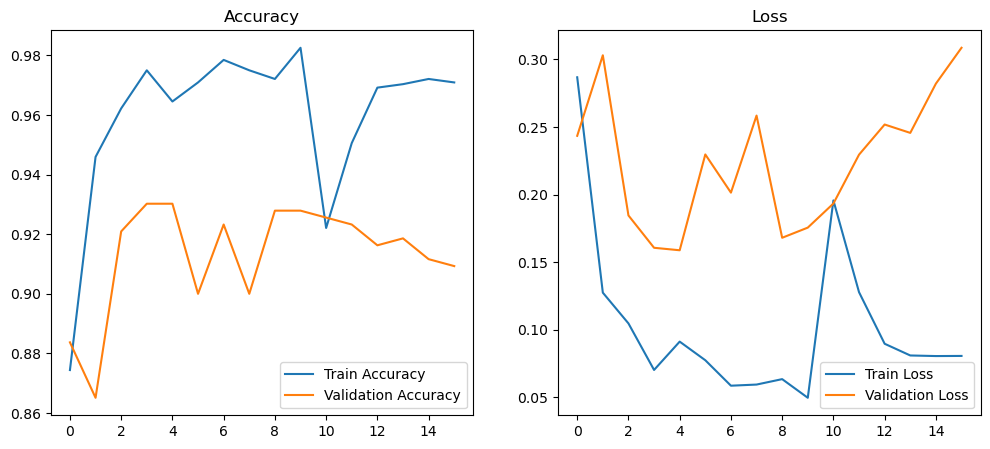

14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


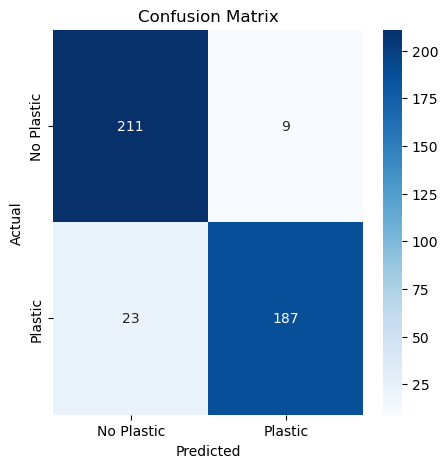

              precision    recall  f1-score   support

  No Plastic       0.90      0.96      0.93       220
     Plastic       0.95      0.89      0.92       210

    accuracy                           0.93       430
   macro avg       0.93      0.92      0.93       430
weighted avg       0.93      0.93      0.93       430



In [13]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

# Predictions on the test set
y_pred = model.predict(test_generator)
y_pred_binary = np.where(y_pred > 0.5, 1, 0).flatten()

# True labels
y_true = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Plastic', 'Plastic'],
            yticklabels=['No Plastic', 'Plastic'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_binary, target_names=['No Plastic', 'Plastic']))


## Results

From the results above. The final model achieved a high accuracy on the test set. Here is a summary of the evaluation metrics, please see below:

<style>
    .metrics-table {
        font-family: Arial, sans-serif;
        border-collapse: collapse;
        width: 60%;
        margin: 20px 0;
    }
    .metrics-table th, .metrics-table td {
        border: 1px solid #ddd;
        padding: 10px;
        text-align: center;
    }
    .metrics-table th {
        background-color: #4CAF50;
        color: white;
    }
    .metrics-table tr:nth-child(even) {
        background-color: #f2f2f2;
    }
    .title {
        font-size: 20px;
        font-weight: bold;
        margin-top: 20px;
    }
</style>

<div class="title">Final Model Evaluation Metrics</div>

<table class="metrics-table">
    <tr>
        <th>Metric</th>
        <th>Value</th>
    </tr>
    <tr>
        <td>Accuracy</td>
        <td>93%</td>
    </tr>
    <tr>
        <td>True Positives (Plastic detected correctly)</td>
        <td>187</td>
    </tr>
    <tr>
        <td>True Negatives (No Plastic detected correctly)</td>
        <td>211</td>
    </tr>
    <tr>
        <td>False Positives</td>
        <td>9</td>
    </tr>
    <tr>
        <td>False Negatives</td>
        <td>23</td>
    </tr>
</table>

<div class="title">Classification Report</div>

<table class="metrics-table">
    <tr>
        <th>Class</th>
        <th>Precision</th>
        <th>Recall</th>
    </tr>
    <tr>
        <td>Plastic</td>
        <td>95%</td>
        <td>89%</td>
    </tr>
    <tr>
        <td>No Plastic</td>
        <td>90%</td>
        <td>96%</td>
    </tr>
</table>

In [14]:
# Save the final model
model.save("microplastic_detector_transfer.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


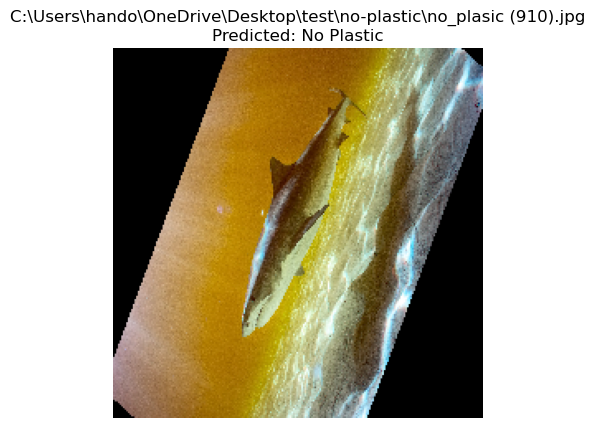

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


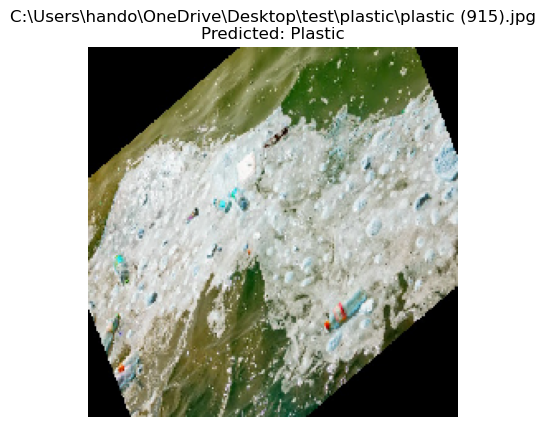

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


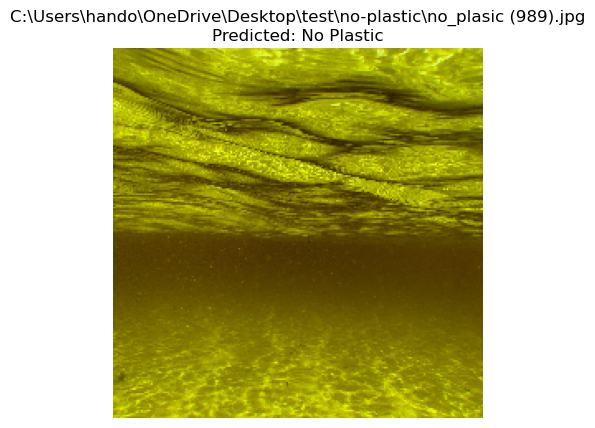

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


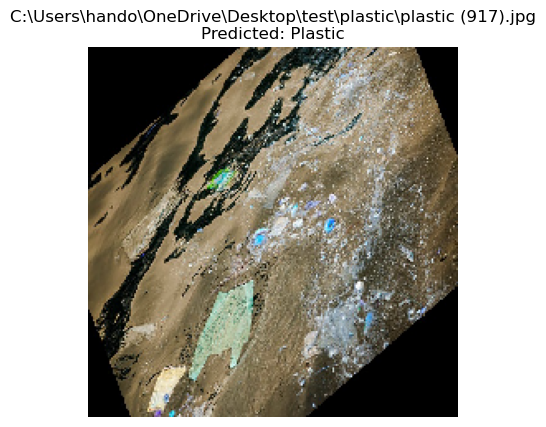

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


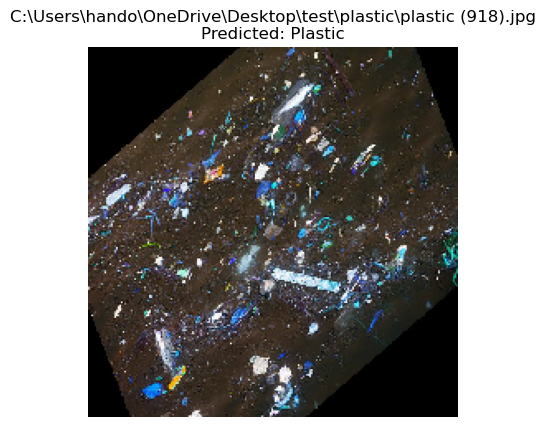

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


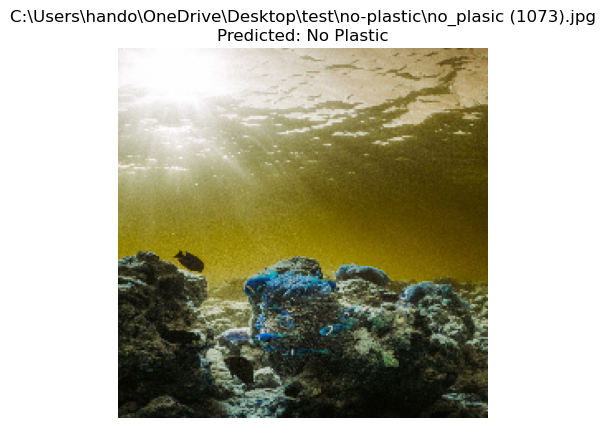

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


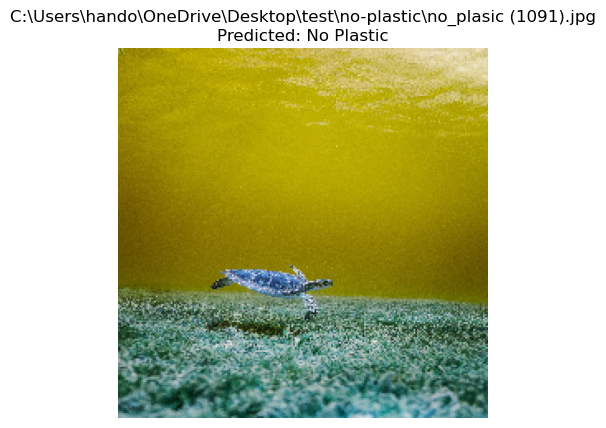

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


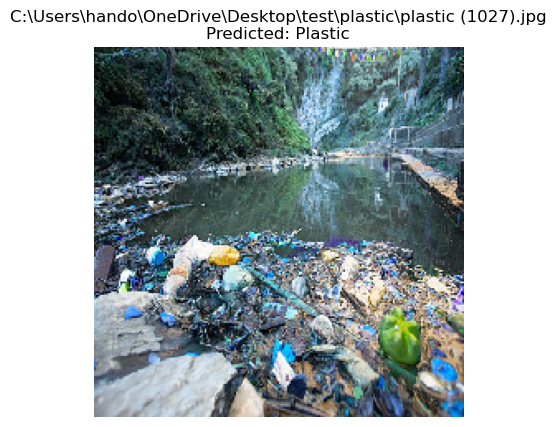

In [41]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np


image_paths = [
    r"C:\Users\hando\OneDrive\Desktop\test\no-plastic\no_plasic (910).jpg",
    r"C:\Users\hando\OneDrive\Desktop\test\plastic\plastic (915).jpg",
    r"C:\Users\hando\OneDrive\Desktop\test\no-plastic\no_plasic (989).jpg",
    r"C:\Users\hando\OneDrive\Desktop\test\plastic\plastic (917).jpg",
    r"C:\Users\hando\OneDrive\Desktop\test\plastic\plastic (918).jpg",
    r"C:\Users\hando\OneDrive\Desktop\test\no-plastic\no_plasic (1073).jpg",
    r"C:\Users\hando\OneDrive\Desktop\test\no-plastic\no_plasic (1091).jpg",
    r"C:\Users\hando\OneDrive\Desktop\test\plastic\plastic (1027).jpg"
]

for img_path in image_paths:
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    label = "Plastic" if prediction[0][0] > 0.5 else "No Plastic"
    
    # Show result
    plt.imshow(img)
    plt.title(f"{img_path}\nPredicted: {label}")
    plt.axis("off")
    plt.show()


## Conclusion

This project demonstrates a successful application of deep learning to the detection of microplastic pollution in underwater images. The transfer learning approach using MobileNetV2 significantly improved classification accuracy compared to training a custom CNN from scratch. The model's high performance and efficiency suggest it can be a valuable tool for environmental monitoring and research.

## Future Work

Model Optimization: <br>
   I aim to experiment different pre-trained models like ResNet50 and EfficientNet and hyperparameter tunning to
   further boost performance.

## Acknowledgement

A huge thanks to SURAJIT MONDAL for allowing me to use his datasets for this project. <br>
Thank you so much SURAJIT MONDAL ദ്ദി ˉ͈̀꒳ˉ͈́ )✧

Additionally, I would like to thank Dr. John Stewart from the Graduate School of Data Intelligence and Technology <br>for your dedication and time teaching the course and providing valuable foundation for this project.

## References

👉 MobileNetV2: MobileNetV2: Inverted Residuals and Linear Bottlenecks
    link: https://arxiv.org/abs/1801.04381

👉 Keras Documentation: ImageDataGenerator
    link: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

👉 Environmental Studies on Microplastic Pollution: Marine Plastic Pollution
    link: https://www.kaggle.com/datasets/surajit651/souvikdataset


1. Wiener, M. (2023, August). New research highlights the problem of microplastic pollution. National Institute of Environmental Health Sciences. https://www.niehs.nih.gov/research/programs/geh/geh_newsletter/2023/8/articles/new_research_highlights_the_problem_of_microplastic_pollution

2. Alfaro-Núñez, A., Astorga, D., Cáceres-Farías, L., et al. (2021). Microplastic pollution in seawater and marine organisms across the Tropical Eastern Pacific and Galápagos. Scientific Reports, 11, 6424. https://doi.org/10.1038/s41598-021-85939-3